# PCA, TSNE analysis of ephys features using AllenSDK

Import the neccessary data from the Allen institute. Using pandas dataframe present the electophysiology features.

In [1]:
from allensdk.core.cell_types_cache import CellTypesCache
from allensdk.api.queries.cell_types_api import CellTypesApi
import pandas as pd
import numpy as np

# Initialize the cache and dget the metadata for cells, download if neccessary (to current directory)
ctc = CellTypesCache(manifest_file='cell_types/manifest.json')
cells = ctc.get_cells()

# Get the ephys features of all cells, download if neccessary
ephys_features = ctc.get_ephys_features()

ef_df = pd.DataFrame(ephys_features)

# List of all ephys feature names
ephys_features = list(ef_df)



Add labels: species, cre_line and dendrite_type to the dataframe to label each cell.

In [2]:
cell_index = {c['id']: c for c in cells}

# Label species, human (Homo Sapiens) or mouse (Mus musculus)
cell_types = [cell_index[cid]['species'] for cid in ef_df['specimen_id']]

ef_df['species'] = pd.Series(cell_types, index=ef_df.index)


# Label cre line
cell_index = {c['id']: c for c in cells}
cre_line = [cell_index[cid]['transgenic_line'] for cid in
                  ef_df['specimen_id']]

ef_df['cre_line'] = pd.Series(cre_line, index=ef_df.index)

# Set label cre line of human cells to 'Human'
for index, row in ef_df.iterrows():
    if "Homo Sapiens" in set(row):
        ef_df.set_value(index, 'cre_line', 'Human')

# Label dendrite type, spiny, aspiny, or sparsely spiny
dendrite_type = [cell_index[cid]['dendrite_type'] for cid in
                  ef_df['specimen_id']]

ef_df['dendrite_type'] = pd.Series(dendrite_type, index=ef_df.index)

#Drop cells without reporter_status = positive
dropped_cells = []
for x in cell_index:
    if cell_index[x]['species'] == 'Mus musculus':
        #print(cell_index[x]['reporter_status'])
        if cell_index[x]['reporter_status'] != 'positive':
            #dropped_cells++
            dropped_cells.append(x)
            
            
for x in dropped_cells:
    cell_index.pop(x)
print('{} cells dropped.'.format(len(dropped_cells)))




/Users/noahjacobs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


105 cells dropped.


Find features with missing data and drop these features from the dataframe.

In [3]:
# Create a list of features that are to be dropped. Example: specimen id and data containing NaN
dropped_features = ['id', 'rheobase_sweep_id', 'rheobase_sweep_number',
                    'thumbnail_sweep_id', 'seal_gohm','vm_for_sag']
print()
# Find features with missing data
for index, column in ef_df.iteritems():
    na_array = pd.isna(column)
    for values in na_array:
        if values == True:
              if column.name not in dropped_features:
                    dropped_features.append(column.name)


dropped_features.sort()

# Drop the list of ephys features used for PCA.
for dropped_item in dropped_features:
    ephys_features.remove(dropped_item)
ephys_features.remove('specimen_id')

print('{} features dropped.'.format(len(dropped_features)))
print('{} features in dataframe.'.format(len(ephys_features)))

# Drop the features in the main dataframe.
ef_df.drop(columns=dropped_features, axis = 1, inplace = True)

print(dropped_features)
print(ephys_features)


25 features dropped.
30 features in dataframe.
['adaptation', 'avg_isi', 'electrode_0_pa', 'fast_trough_t_ramp', 'fast_trough_v_ramp', 'id', 'peak_t_ramp', 'peak_v_ramp', 'rheobase_sweep_id', 'rheobase_sweep_number', 'seal_gohm', 'slow_trough_t_long_square', 'slow_trough_t_ramp', 'slow_trough_t_short_square', 'slow_trough_v_long_square', 'slow_trough_v_ramp', 'slow_trough_v_short_square', 'threshold_i_ramp', 'threshold_t_ramp', 'threshold_v_ramp', 'thumbnail_sweep_id', 'trough_t_ramp', 'trough_v_ramp', 'upstroke_downstroke_ratio_ramp', 'vm_for_sag']
['f_i_curve_slope', 'fast_trough_t_long_square', 'fast_trough_t_short_square', 'fast_trough_v_long_square', 'fast_trough_v_short_square', 'has_burst', 'has_delay', 'has_pause', 'input_resistance_mohm', 'latency', 'peak_t_long_square', 'peak_t_short_square', 'peak_v_long_square', 'peak_v_short_square', 'ri', 'sag', 'tau', 'threshold_i_long_square', 'threshold_i_short_square', 'threshold_t_long_square', 'threshold_t_short_square', 'threshold

Create two more dataframe for mouse and human data.

In [4]:
# Mouse dataframe
mouse_ef_df = ef_df[ef_df['species']=='Mus musculus']
# Human dataframe
human_ef_df = ef_df[ef_df['species']=='Homo Sapiens']

print('Total number of human cells with electrophysiology features: {}'.format(len(human_ef_df)))
print('Number of human spiny cells: {}'.format(len(human_ef_df[human_ef_df['dendrite_type']=='spiny'])))
print('Number of human aspiny cells: {}'.format(len(human_ef_df[human_ef_df['dendrite_type']=='aspiny'])))
print('Number of human sparsely spiny cells: {}\n'.format(len(human_ef_df[human_ef_df['dendrite_type']=='sparsely spiny'])))

print('Total number of mouse cells with electrophysiology features: {}'.format(len(mouse_ef_df)))
print('Number of mouse spiny cells: {}'.format(len(mouse_ef_df[mouse_ef_df['dendrite_type']=='spiny'])))
print('Number of mouse aspiny cells: {}'.format(len(mouse_ef_df[mouse_ef_df['dendrite_type']=='aspiny'])))
print('Number of mouse sparsely spiny cells: {}'.format(len(mouse_ef_df[mouse_ef_df['dendrite_type']=='sparsely spiny'])))

Total number of human cells with electrophysiology features: 413
Number of human spiny cells: 321
Number of human aspiny cells: 79
Number of human sparsely spiny cells: 13

Total number of mouse cells with electrophysiology features: 1920
Number of mouse spiny cells: 892
Number of mouse aspiny cells: 921
Number of mouse sparsely spiny cells: 107


Import tools for principal component analysis from sklearn. Perform pricipal component analysis on ephys features without missing data.

In [5]:
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

# Separate out the features
x = ef_df.loc[:, ephys_features].values

# Standardize the features
x = StandardScaler().fit_transform(x)

# Perform a 2 component PCA
pca = PCA(n_components=2)

principalComponents = pca.fit_transform(x)

# Overall PCA data
principalDf = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'])

print('Variance explained per principal component: {}'.format(pca.explained_variance_ratio_))

# Create a PCA dataframe with species, dendrite type, specimen id, cre line labels
finalDf = pd.concat([principalDf, ef_df[['species']]], axis = 1)
finalDf = pd.concat([finalDf, ef_df['dendrite_type']], axis = 1)
finalDf = pd.concat([finalDf, ef_df['specimen_id']], axis = 1)
finalDf = pd.concat([finalDf, ef_df[['cre_line']]], axis = 1)

Variance explained per principal component: [0.22321079 0.16085118]


/Users/noahjacobs/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/noahjacobs/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Import seaborn and use it to graph the result of the PCA

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

#Plot PCA graphs with two different visualization
plt.figure(figsize=(8, 8))
plt.title('2 Component PCA Colored by Species')
ax = sns.scatterplot(x="PC1", y="PC2", hue="species", style="dendrite_type", alpha=0.5, data=finalDf)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title="Cell Types")

plt.figure(figsize=(8, 8))
plt.title('2 Component PCA Colored by Dendrite Type')
ax = sns.scatterplot(x="PC1", y="PC2", hue="dendrite_type", style="species", alpha=0.5, data=finalDf)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title="Cell Types")

Perform a t-SNE analysis on the ephys features.

In [7]:
from sklearn.manifold import TSNE
import time

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=1000)
tsne_results = tsne.fit_transform(x)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2333 samples in 0.002s...
[t-SNE] Computed neighbors for 2333 samples in 0.319s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2333
[t-SNE] Computed conditional probabilities for sample 2000 / 2333
[t-SNE] Computed conditional probabilities for sample 2333 / 2333
[t-SNE] Mean sigma: 1.245149
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.714783
[t-SNE] KL divergence after 1000 iterations: 1.465032
t-SNE done! Time elapsed: 16.654659032821655 seconds


Create a dataframe for the t-SNE analysis to be plotted.

In [8]:
# Create a dataframe from the t-SNE results
tsneDf = pd.DataFrame(data = tsne_results, columns = ['x_tsne', 'y_tsne'])

# Create a t-SNE dataframe with species, dendrite type, specimen id, cre line labels
final_tsne_Df = pd.concat([tsneDf, ef_df[['species']]], axis = 1)
final_tsne_Df = pd.concat([final_tsne_Df, ef_df[['dendrite_type']]], axis = 1)
final_tsne_Df = pd.concat([final_tsne_Df, ef_df[['specimen_id']]], axis = 1)
final_tsne_Df = pd.concat([final_tsne_Df, ef_df[['cre_line']]], axis = 1)

Graph the t-SNE analysis by cell type.

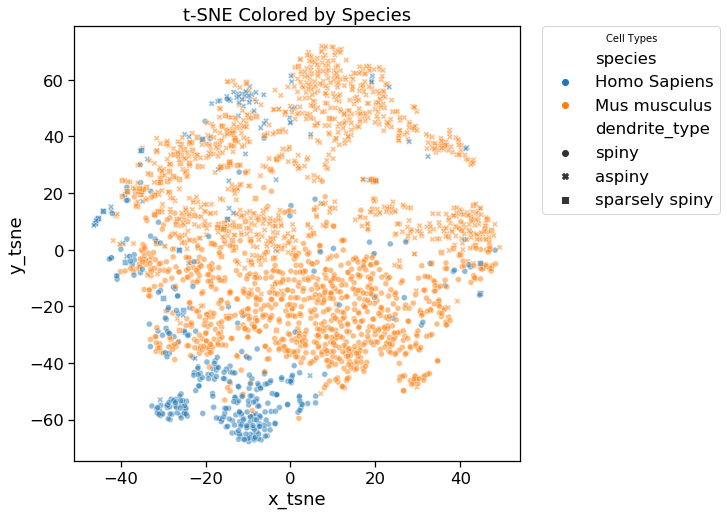

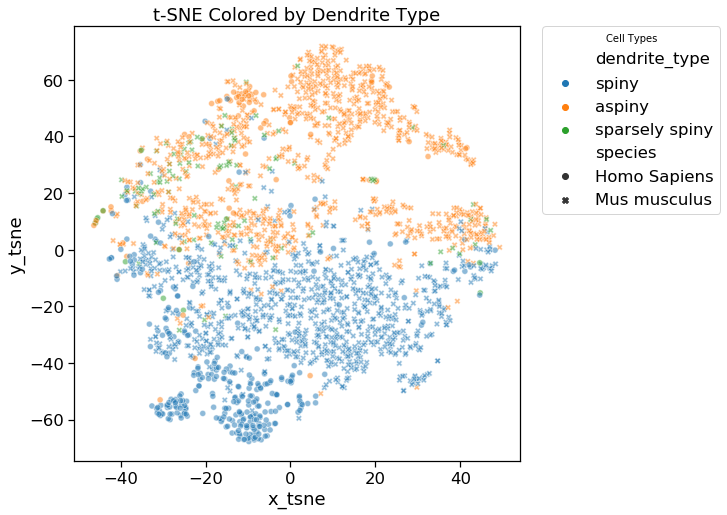

In [9]:
#Plot t-SNE graphs with two different visualization
plt.figure(figsize=(8, 8))
plt.title('t-SNE Colored by Species')
ax = sns.scatterplot(x="x_tsne", y="y_tsne", hue="species", style="dendrite_type",  alpha=0.5, data=final_tsne_Df)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title="Cell Types")

plt.figure(figsize=(8, 8))
plt.title('t-SNE Colored by Dendrite Type')
ax = sns.scatterplot(x="x_tsne", y="y_tsne", hue="dendrite_type", style="species", alpha=0.5, data=final_tsne_Df)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title="Cell Types")

From csv file driver_lines_anno, create color palette labels for cooresponding cre driver line of each cell. (Note: humans are labeled with black)

In [10]:
# Read the csv file from indicated path. Requires driver_line_anno.csv file
csv = pd.read_csv("/Users/noahjacobs/Triplab/Notebook/Test/driver_lines_anno.csv")

# Create cre_line color palette
cre_line_palette = {}
for index, row in csv.iterrows():
    cre_line_palette.update({row['driver_lines_label']:row['driver_lines_color']})

cre_line_palette.update({'Human':'#000000'})
cre_line_palette.update({'Mouse':'#FF0000'})
# Extraneous cre_line outside of file.
cre_line_palette.update({'Rorb-IRES2-Cre':'#2B8C88'})
cre_line_palette.update({'Esr2-IRES2-Cre-neo':'#5100FF'})
cre_line_palette.update({'Slc32a1-T2A-FlpO|Vipr2-IRES2-Cre':'#DF2166'})
cre_line_palette.update({'Vipr2-IRES2-Cre-neo':'#76958C'})
cre_line_palette.update({'Esr2-IRES2-Cre|PhiC31-neo':'#5100FF'})
cre_line_palette.update({'Esr2-IRES2-Cre-neo|PhiC31-neo':'#5100FF'})
cre_line_palette.update({'Pvalb-T2A-FlpO|Vipr2-IRES2-Cre':'#FF197F'})
cre_line_palette.update({'Pvalb-T2A-CreERT2':'#FF197F'})
cre_line_palette.update({'Nos1-CreERT2|Sst-IRES-FlpO':'#FFA500'}) #orange
cre_line_palette.update({'Chrna2-Cre_OE25|Pvalb-T2A-Dre':'#FF0000'}) #red
cre_line_palette.update({'Htr3a-Cre_NO152|Pvalb-T2A-Dre':'#C71585'}) #red purple

Generate t-SNE graph labeled by clusters of cre line and human cells using our predetermined color palette.

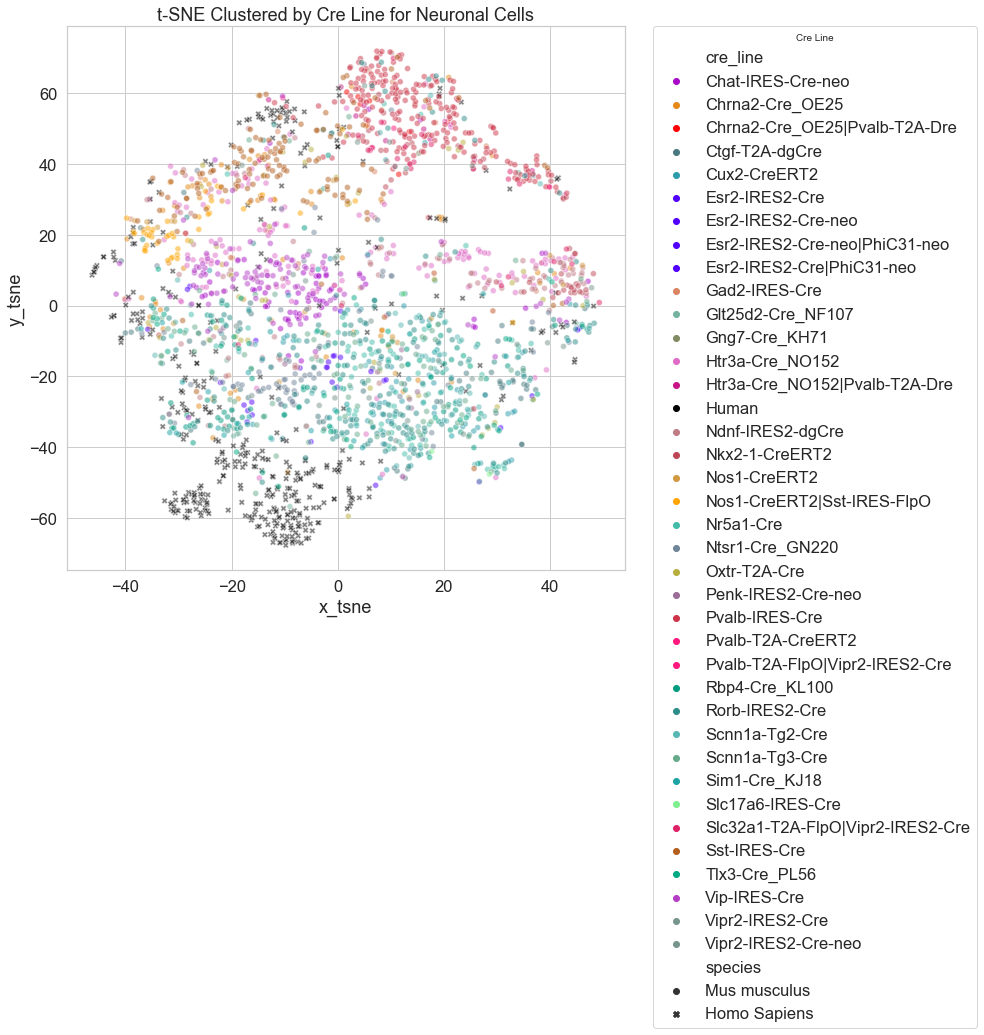

In [11]:
# Sort the t_SNE dataframe alphabetically by cre_line.
sorted_creline = final_tsne_Df.sort_values(by=['cre_line'])

sns.set_style("whitegrid")
plt.figure(figsize=(10, 10))
plt.title('t-SNE Clustered by Cre Line for Neuronal Cells')
ax = sns.scatterplot(x="x_tsne", y="y_tsne", hue="cre_line", style="species", 
                     alpha=0.5, data=sorted_creline, palette=cre_line_palette)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title="Cre Line")

For each human cell, find the 5 nearest mouse cell neighbors within the t-SNE plot. Using the sklearn NearestNeighbors toolkit to find its 5 nearest mouse cell neighbors.

In [12]:
# Isolate only mouse cells to contain only t-SNE values and specimen id of each mouse cell
tsne_mouse = final_tsne_Df[final_tsne_Df['species'] == 'Mus musculus']
tsne_mouse = tsne_mouse.drop(['species', 'dendrite_type'], axis=1)

# Isolate only human cells to contain only t-SNE values and specimen id of each human cell
tsne_human = final_tsne_Df[final_tsne_Df['cre_line'] == 'Human']
tsne_human = tsne_human.drop(['species', 'dendrite_type'], axis=1)

In [13]:
from sklearn.neighbors import NearestNeighbors
## Instantiate the model with 5 neighbors. 
knn = NearestNeighbors(n_neighbors=5)

## Fit the model on the training data.
knn.fit(tsne_mouse.drop(['specimen_id', 'cre_line'], axis=1))

# The list of indices of the 5 closest neighbours for each human cell.
nearest = knn.kneighbors(tsne_human.drop(['specimen_id', 'cre_line'], axis=1), return_distance=False)

# Create a dictionary where the key is the index of the human cell, and the keys are the indices of 
# its five mouse neighbours.
five_nearest = {}
i = 0
for index, row in tsne_human.iterrows():
    five_nearest[int(index)] = nearest[i]
    i += 1

Create a dataframe that holds the information for the human cell and its five closest neighbors.

In [14]:
# Using nearest and five_nearest, create a dictionary holding specimen_id of the human cell as keys
# and its 5 mouse neighbor as values
sample_id_cluster = []
i=0
for keys in five_nearest.keys():
    sample_id_cluster.append([int(tsne_human.loc[keys]['specimen_id'])])
    for item in nearest[i]:
        sample_id_cluster[i].append(tsne_mouse.iloc[item]['specimen_id'])
    i += 1
    
sample_id_dict = {}
for id in sample_id_cluster:
    sample_id_dict[id[0]] = id[1:6]

# Create a similar dictionary holding specimen_id of the human cell as keys
# and the cre line of its 5 mouse neighbor as values
creline_cluster = []
i=0
for keys in five_nearest.keys():
    creline_cluster.append([int(tsne_human.loc[keys]['specimen_id'])])
    for item in nearest[i]:
        creline_cluster[i].append(tsne_mouse.iloc[item]['cre_line'])
    i += 1

creline_dict = {}
for id in creline_cluster:
    creline_dict[id[0]] = id[1:6]

# Concatanate the two dictionaries into one dataframe df_5_near holding the specimen id of the human cell
# and its 5 closest mouse neighbours' id and cre line.
data = []
for value in sample_id_dict.values():
    data.append(value)
    
i=0
for value in creline_dict.values():
    data[i].extend(value)
    i+=1

df_5_near = pd.DataFrame(data, index = sample_id_dict.keys(), columns= ['mouse_1', 'mouse_2','mouse_3', 
        'mouse_4', 'mouse_5', 'mouse_1_cre', 'mouse_2_cre', 'mouse_3_cre', 'mouse_4_cre', 'mouse_5_cre'])

# This will display the dataframe containing the specimen id of the human and its 5 mouse neighbors.
df_5_near

,mouse_1,mouse_2,mouse_3,mouse_4,mouse_5,mouse_1_cre,mouse_2_cre,mouse_3_cre,mouse_4_cre,mouse_5_cre
529878215,572609348,557874460,584635140,480273887,584682764,Glt25d2-Cre_NF107,Tlx3-Cre_PL56,Scnn1a-Tg3-Cre,Rorb-IRES2-Cre,Oxtr-T2A-Cre
548459652,572609348,584635140,557874460,480273887,504179737,Glt25d2-Cre_NF107,Scnn1a-Tg3-Cre,Tlx3-Cre_PL56,Rorb-IRES2-Cre,Htr3a-Cre_NO152
569095789,501799874,476263004,490259231,485938494,501841672,Ctgf-T2A-dgCre,Scnn1a-Tg3-Cre,Ntsr1-Cre_GN220,Ntsr1-Cre_GN220,Ctgf-T2A-dgCre
528706755,584682764,572609348,581394360,486262299,557874460,Oxtr-T2A-Cre,Glt25d2-Cre_NF107,Esr2-IRES2-Cre,Cux2-CreERT2,Tlx3-Cre_PL56
508279351,584635140,480273887,504179737,325941643,557874460,Scnn1a-Tg3-Cre,Rorb-IRES2-Cre,Htr3a-Cre_NO152,Rbp4-Cre_KL100,Tlx3-Cre_PL56
643582610,481001895,555898896,569958754,567320213,569739534,Htr3a-Cre_NO152,Chrna2-Cre_OE25,Chrna2-Cre_OE25,Chrna2-Cre_OE25,Chrna2-Cre_OE25
530097064,557874460,556363725,572609348,480273887,504179737,Tlx3-Cre_PL56,Chrna2-Cre_OE25,Glt25d2-Cre_NF107,Rorb-IRES2-Cre,Htr3a-Cre_NO152
529909601,572609348,584635140,557874460,480273887,504179737,Glt25d2-Cre_NF107,Scnn1a-Tg3-Cre,Tlx3-Cre_PL56,Rorb-IRES2-Cre,Htr3a-Cre_NO152
569820026,501014504,566463606,490916882,569412397,564408650,Rbp4-Cre_KL100,Chrna2-Cre_OE25,Rbp4-Cre_KL100,Ndnf-IRES2-dgCre,Ndnf-IRES2-dgCre
542137330,569664731,515524026,480116737,584628220,558612809,Chrna2-Cre_OE25,Rbp4-Cre_KL100,Rorb-IRES2-Cre,Scnn1a-Tg3-Cre,Tlx3-Cre_PL56


To graph out each of the human cell and its 5 neighbours, we create a new dataframe to graph the 6 data points. 

In [15]:
cre_line_5 = ['Human']
x_tsne_5 = []
y_tsne_5 = []

# Specify the specimen id of the human cell
human_specimen = 528016025 #529878215 

# This will be the index that stores the human cell in the tsne_human list
number = (tsne_human[tsne_human['specimen_id']==human_specimen].index[0])

cre_line_5.append(df_5_near.loc[human_specimen]['mouse_1_cre'])
cre_line_5.append(df_5_near.loc[human_specimen]['mouse_2_cre'])
cre_line_5.append(df_5_near.loc[human_specimen]['mouse_3_cre'])
cre_line_5.append(df_5_near.loc[human_specimen]['mouse_4_cre'])
cre_line_5.append(df_5_near.loc[human_specimen]['mouse_5_cre'])

x_tsne_5.append((tsne_human[tsne_human['specimen_id']==human_specimen]).x_tsne)
for item in five_nearest[number]:
    x_tsne_5.append(tsne_mouse.iloc[item]['x_tsne'])

y_tsne_5.append((tsne_human[tsne_human['specimen_id']==human_specimen]).y_tsne)
for item in five_nearest[number]:
    y_tsne_5.append(tsne_mouse.iloc[item]['y_tsne'])



In [16]:
# This contains information about the creline, and the tSNE values of the human cell and its 5 neighbors
data_5 = {'cre_line':cre_line_5, 'x_tsne':x_tsne_5, 'y_tsne':y_tsne_5}
dataframe_5 = pd.DataFrame(data_5)


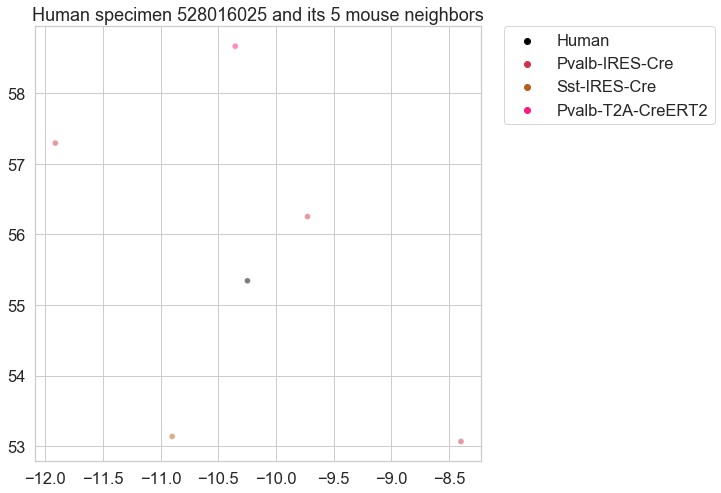

In [17]:
# Plot the human cell and its 5 nearest neighbors on the tSNE plot
sns.set_style("whitegrid")
plt.figure(figsize=(8, 8))
plt.title('Human specimen {} and its 5 mouse neighbors'.format(human_specimen))
ax = sns.scatterplot(x="x_tsne", y="y_tsne", hue="cre_line", alpha=0.5, data=data_5, palette=cre_line_palette)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [18]:
averages = {}
for x in mouse_ef_df:
    if x == 'has_burst' or x == 'has_delay'or x == 'has_pause' or x == 'species' or x == 'cre_line' or x == 'dendrite_type' or x == 'specimen_id':
        print('Skipping ' + x)
    else:
        total = 0
        runs = 0
        for z in mouse_ef_df[x]:
            if type(z) is str:
                print(z)
            total = total + z
            runs = runs + 1
        averages[x] = total/runs

        

Skipping has_burst
Skipping has_delay
Skipping has_pause
Skipping specimen_id
Skipping species
Skipping cre_line
Skipping dendrite_type


Skipping has_burst
Skipping has_delay
Skipping has_pause
Skipping specimen_id


/Users/noahjacobs/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Skipping species
Skipping cre_line
Skipping dendrite_type


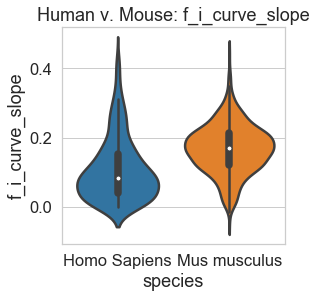

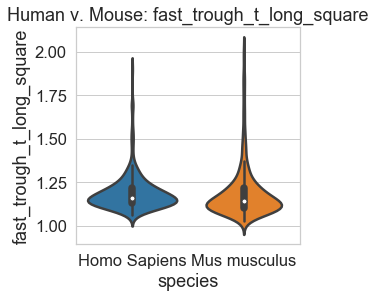

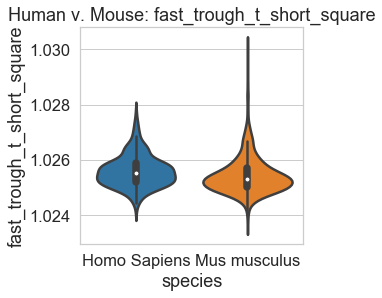

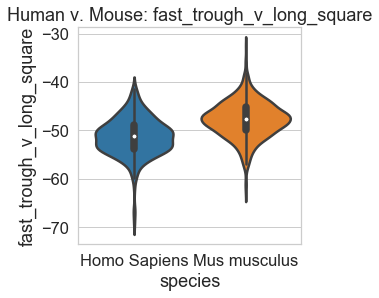

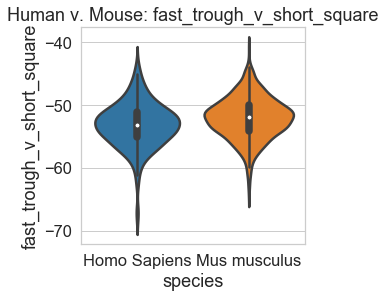

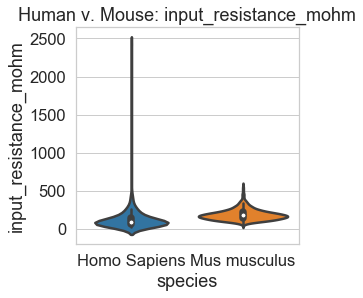

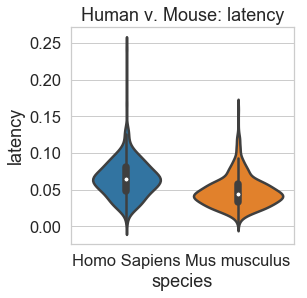

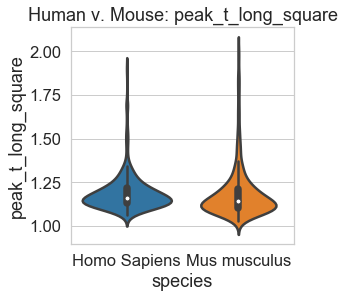

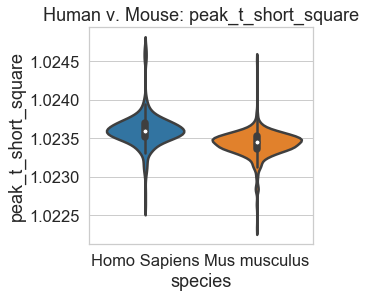

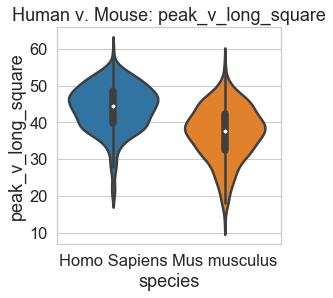

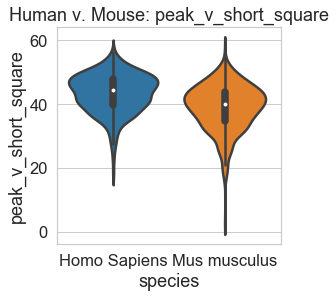

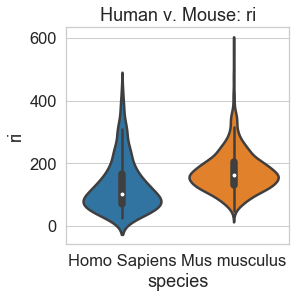

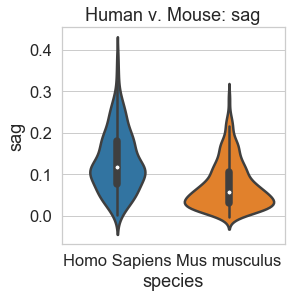

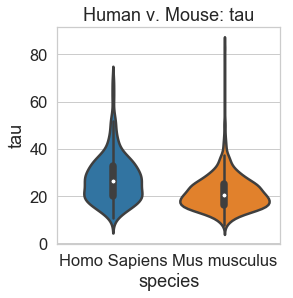

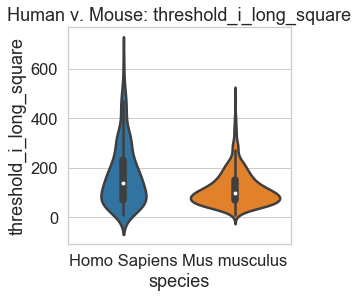

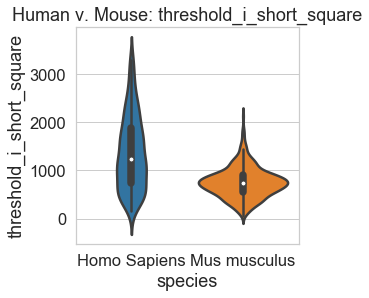

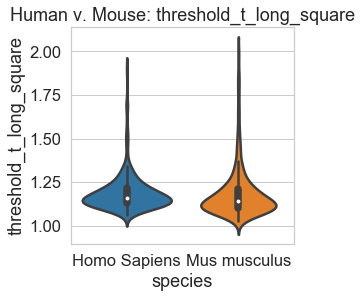

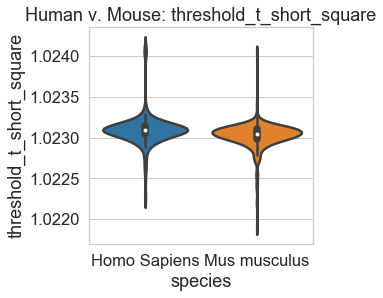

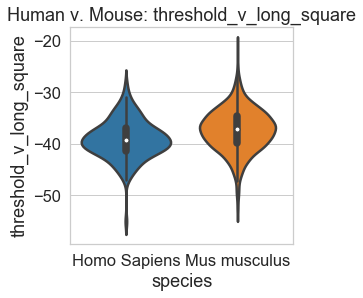

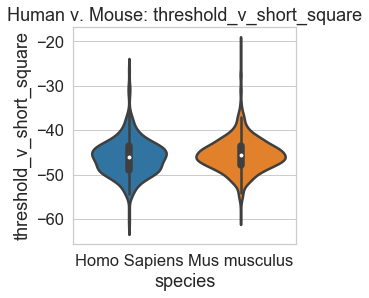

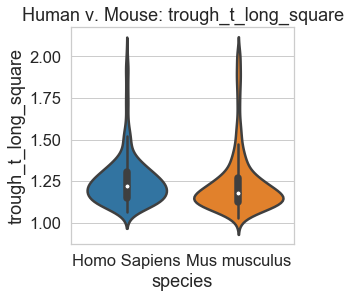

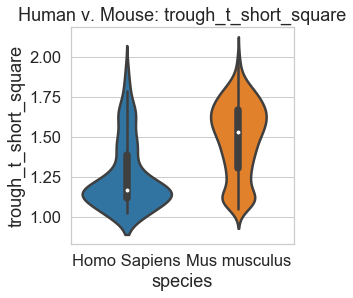

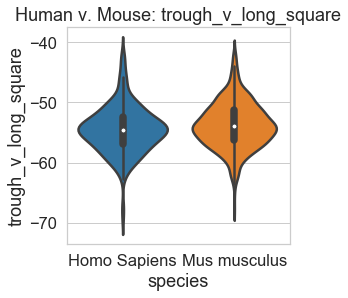

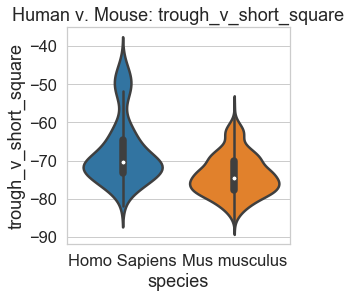

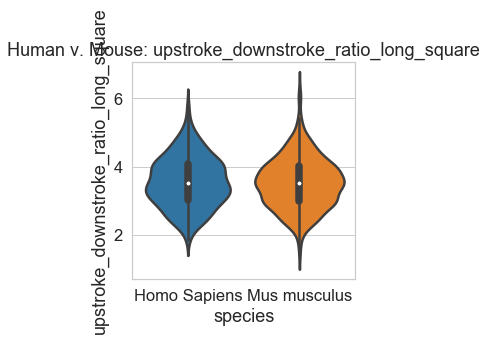

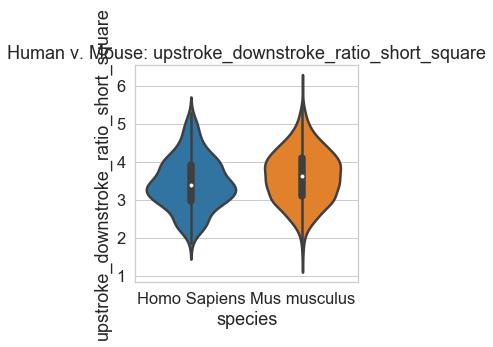

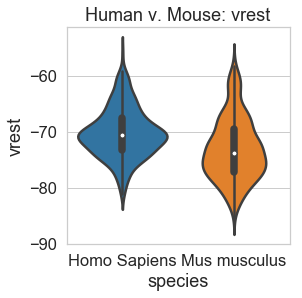

In [19]:
non_numeric = ['has_burst','has_delay','has_pause','species','cre_line','dendrite_type','specimen_id']
for z in ef_df:
    if z in non_numeric:
        print('Skipping ' + z)
    else:
        plt.figure(figsize=(4, 4))
        plt.title('Human v. Mouse: ' + z)
        sns.violinplot(x = "species", y = z, data =ef_df[ef_df.dendrite_type == 'spiny'])
    

In [20]:
from string import ascii_letters
histogram_intersection = lambda a, b: np.minimum(a, b).sum().round(decimals=1)
cors = ef_df.corr(method = 'spearman')

cors = cors.drop("has_burst", axis = 1)
cors = cors.drop("has_burst")
cors = cors.drop("has_delay", axis = 1)
cors = cors.drop("has_delay")
cors = cors.drop("has_pause", axis = 1)
cors = cors.drop("has_pause")


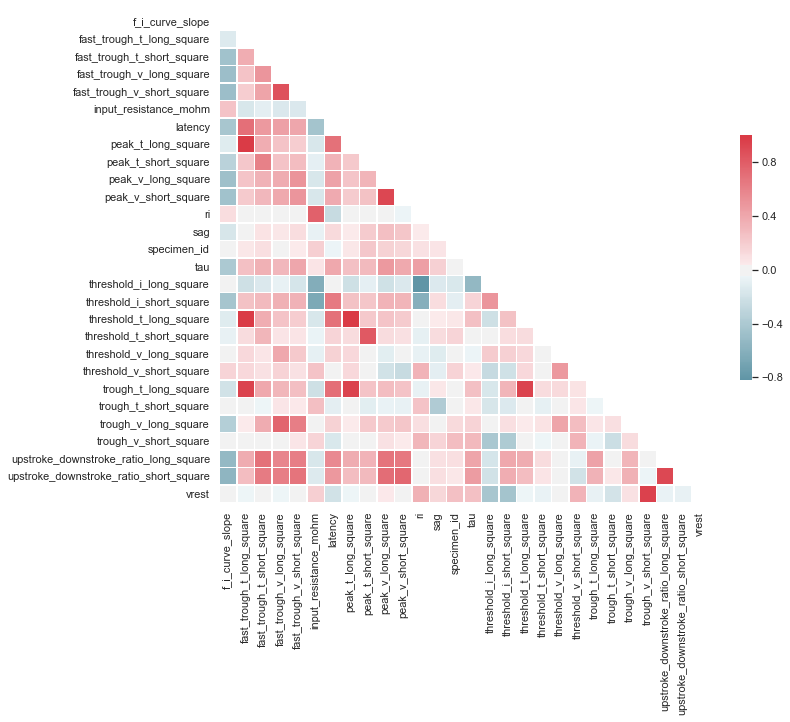

In [21]:
sns.set(style="white")

mask = np.zeros_like(cors, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(cors, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

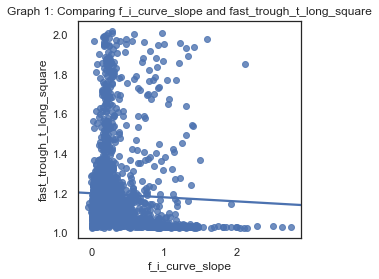

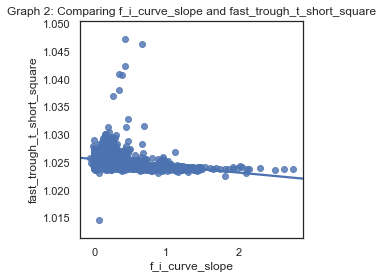

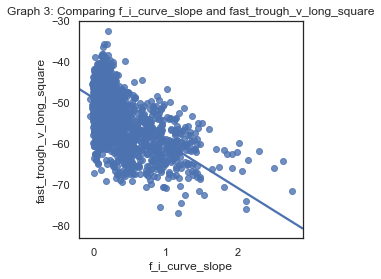

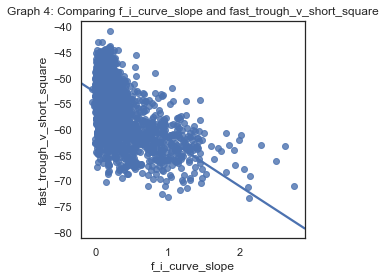

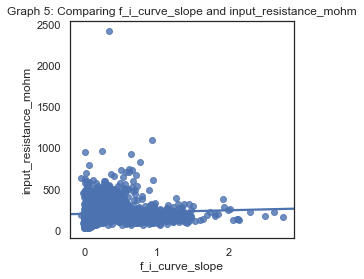

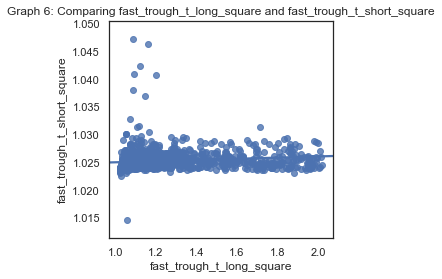

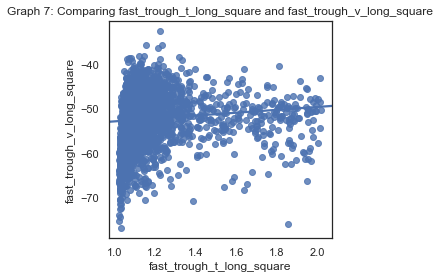

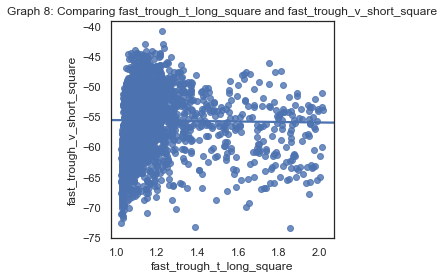

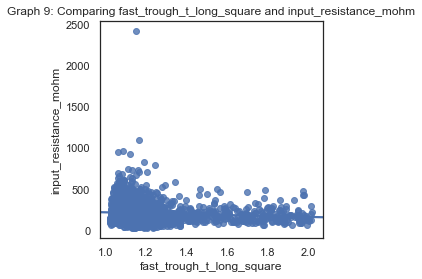

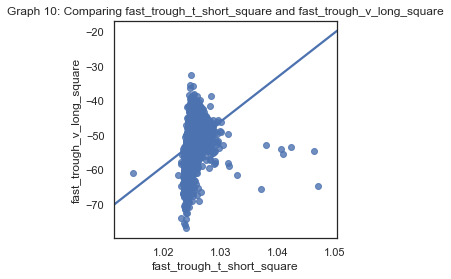

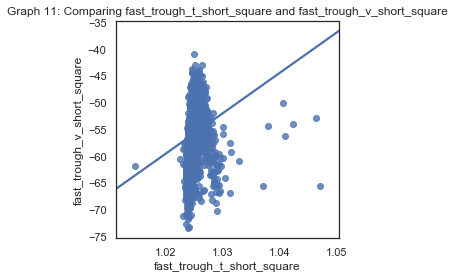

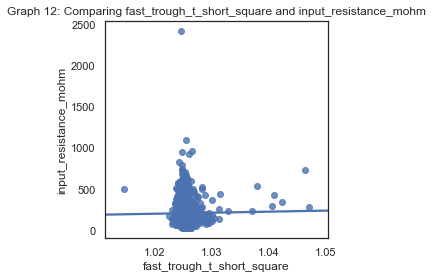

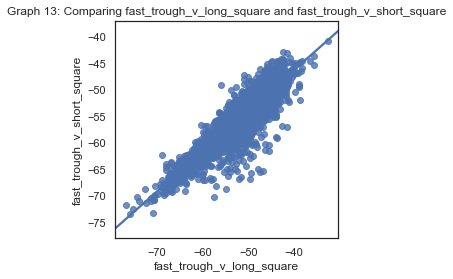

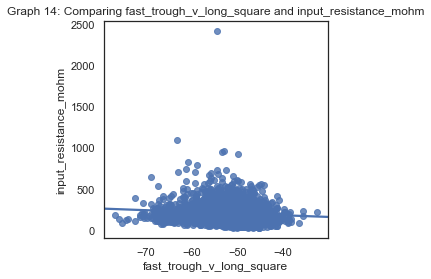

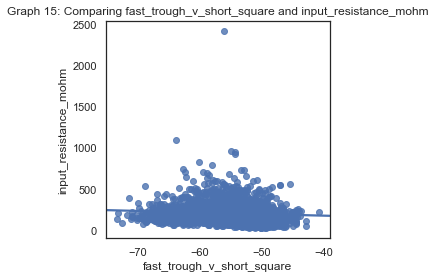

In [22]:
#Skipping this due to delay
plt_feat2 = ['f_i_curve_slope', 'fast_trough_t_long_square', 'fast_trough_t_short_square', 
             'fast_trough_v_long_square','fast_trough_v_short_square', 'input_resistance_mohm']
done = []
counter = 0

for i in plt_feat2:
    for j in plt_feat2:
        if i != j and j not in done:
            counter = counter + 1
            plt.figure(figsize=(4, 4))
            plt.title('Graph ' + str(counter) + ': Comparing ' + i + ' and ' + j)
            sns.regplot(x = i, y = j, data = ef_df, ci=None)
    done.append(i)

In [23]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
from sklearn import datasets
from sklearn.feature_selection import RFE

pred_ephys_features = ephys_features.copy()
#pred_ephys_features.remove('vrest')
#pred_ephys_features.remove('latency')
#print('Dropping "vrest" and "latency"')

X = mouse_ef_df.loc[:, pred_ephys_features].values
y = mouse_ef_df.loc[:, 'dendrite_type'].values

dendrite_model = linear_model.LogisticRegression(penalty='l1', solver='saga', max_iter=100)
dendrite_model.fit(X,y)
print('Creating model for predicting dendrite_type:')


dendrite_model.score(X, y)

/Users/noahjacobs/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/noahjacobs/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/noahjacobs/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Creating model for predicting dendrite_type:


/Users/noahjacobs/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.8572916666666667

In [24]:
from sklearn import metrics
print('Testing model accuracy on Humans:')
human_feat = human_ef_df.loc[:, pred_ephys_features].values
predicted_ys = dendrite_model.predict(human_feat)

metrics.accuracy_score(human_ef_df.loc[:, 'dendrite_type'], predicted_ys)


Testing model accuracy on Humans:


0.9152542372881356

In [25]:
from sklearn.preprocessing import StandardScaler

N = mouse_ef_df.loc[:, pred_ephys_features].values
b = mouse_ef_df.loc[:, 'cre_line'].values

print(type(b[0]))

cre_line_model = linear_model.LogisticRegression(penalty='l1', solver='saga', max_iter=100)
fiter = cre_line_model.fit(StandardScaler().fit_transform(N),b)

#z = human_ef_df.loc[:, pred_ephys_features].values
cre_line_model.score(StandardScaler().fit_transform(N), b)

/Users/noahjacobs/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/noahjacobs/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/noahjacobs/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/noahjacobs/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


<class 'str'>


/Users/noahjacobs/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/noahjacobs/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/noahjacobs/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/noahjacobs/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/noahjacobs/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: Convergence

0.4708333333333333

In [26]:
N = mouse_ef_df.loc[:, pred_ephys_features].values
#print(type(ephys_features))
#print(type(fiter.coef_[0]))
#list(set(mouse_ef_df.loc[:, 'cre_line'].values))

In [27]:
a = np.array(fiter.coef_[0])
b = np.array(pred_ephys_features)
'''c = np.array([b,a])
c = np.reshape(c, 56,order='F')'''
c = pd.DataFrame(a,b)

c

,0
f_i_curve_slope,-0.688594
fast_trough_t_long_square,0.050639
fast_trough_t_short_square,0.000000
fast_trough_v_long_square,0.014194
fast_trough_v_short_square,-0.494357
has_burst,0.000000
has_delay,0.000000
has_pause,0.000000
input_resistance_mohm,-0.176854
latency,-1.335250


In [28]:
coefficients = pd.concat([pd.DataFrame(N),pd.DataFrame(np.transpose(fiter.coef_))], axis = 1)
coefficients

,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
0,0.526786,1.15784,1.02539,-59.5,-59.941,False,False,False,224.58,0.01336,...,0.197663,-0.659226,0.000000,0.000000,0.470248,-0.703148,-0.033789,-6.670674e-01,0.310849,0.000000
1,0.154255,1.98917,1.02873,-47.5312,-65.5,False,False,False,151.193,0.14301,...,0.018655,-0.004608,-0.054702,-0.027869,0.081000,-0.242743,-0.025674,0.000000e+00,0.033707,0.000000
2,0.171404,1.08198,1.02562,-48.4375,-51.4063,False,False,False,171.53,0.02584,...,0.000000,0.214808,-0.043983,0.000000,0.013082,-0.300469,0.086467,-1.577846e-01,-0.054515,0.000000
3,0.573864,1.09606,1.02541,-48.9688,-57.7812,False,False,False,193.251,0.04022,...,1.104680,0.193237,0.414296,0.000000,-0.116027,-0.479709,0.000000,-4.819148e-01,0.000000,0.000000
4,0.213502,1.28154,1.02592,-49.0313,-52.6813,False,False,False,206.175,0.04188,...,0.204553,0.749311,-0.621570,0.000000,0.788942,-0.956383,0.197605,-4.020553e-02,0.000000,0.000000
5,1.92849,1.14568,1.0241,-65.8125,-66.875,False,False,False,288.548,0.00594,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
6,0.0529762,1.20422,1.026,-48.0312,-51.825,False,False,False,228.866,0.09052,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
7,0.0383906,1.09738,1.02469,-56.5,-60.8375,False,False,False,513.464,0.02296,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
8,0.223864,1.19024,1.02536,-44.9375,-47.3958,False,False,False,144.849,0.073065,...,-0.422385,0.109682,0.096461,0.171837,-0.023501,-0.464877,0.203608,4.950080e-01,-0.037971,0.000000
9,0.636671,1.7291,1.02399,-60.9688,-66.8563,False,False,False,124.288,0.49862,...,0.038772,0.000000,0.000000,0.000000,-0.152561,0.108172,0.202283,-5.871508e-01,-0.271572,0.000000


In [29]:
#No human cre_lines to test on

print('Testing model accuracy on Humans:')
human_feat = human_ef_df.loc[:, pred_ephys_features].values
predicted_bs = cre_line_model.predict(human_feat)
#print(predicted_bs)

#print(.random_state)

metrics.accuracy_score(human_ef_df.loc[:, 'cre_line'], predicted_bs)

Testing model accuracy on Humans:


0.0

In [30]:
'''import random

F = mouse_ef_df.loc[:, pred_ephys_features].values
g = mouse_ef_df.loc[:, 'cre_line'].values

shuf_g = g
random.shuffle(shuf_g)


clf3 = linear_model.LogisticRegression()
clf3.fit(F,shuf_g)


clf3.score(X, shuf_g)'''

"import random\n\nF = mouse_ef_df.loc[:, pred_ephys_features].values\ng = mouse_ef_df.loc[:, 'cre_line'].values\n\nshuf_g = g\nrandom.shuffle(shuf_g)\n\n\nclf3 = linear_model.LogisticRegression()\nclf3.fit(F,shuf_g)\n\n\nclf3.score(X, shuf_g)"

In [31]:
csv2 = pd.read_excel("/Users/noahjacobs/Triplab/Notebook/Test/e-types_Allen.xlsx")
e_type = ef_df.merge(csv2,on='specimen_id')
e_type = e_type.dropna(axis = 0, subset=['e-type'])

csv3 = pd.read_excel("/Users/noahjacobs/Triplab/Notebook/Test/e-types_Allen.xlsx")
m_type= ef_df.merge(csv3,on='specimen_id')
m_type = m_type.dropna(axis = 0, subset=['m-type'])

In [32]:
e_type.to_csv(path_or_buf="/Users/noahjacobs/Triplab/Notebook/Test/e_type.csv")
m_type.to_csv(path_or_buf="/Users/noahjacobs/Triplab/Notebook/Test/m_type.csv")

In [33]:
mouse_e_type = e_type[e_type['species']=='Mus musculus']
human_e_type = e_type[e_type['species']=='Homo Sapiens']
print(human_e_type)

Empty DataFrame
Columns: [f_i_curve_slope, fast_trough_t_long_square, fast_trough_t_short_square, fast_trough_v_long_square, fast_trough_v_short_square, has_burst, has_delay, has_pause, input_resistance_mohm, latency, peak_t_long_square, peak_t_short_square, peak_v_long_square, peak_v_short_square, ri, sag, specimen_id, tau, threshold_i_long_square, threshold_i_short_square, threshold_t_long_square, threshold_t_short_square, threshold_v_long_square, threshold_v_short_square, trough_t_long_square, trough_t_short_square, trough_v_long_square, trough_v_short_square, upstroke_downstroke_ratio_long_square, upstroke_downstroke_ratio_short_square, vrest, species, cre_line, dendrite_type, e-type, m-type, me-type, upright_angle, soma_distance_from_pia, estimated_shrinkage_factor, estimated_slice_angle]
Index: []

[0 rows x 41 columns]


In [34]:
L = mouse_e_type.loc[:, pred_ephys_features].values
p = mouse_e_type.loc[:, 'e-type'].values


print(type(L[0][0]))
e_type_model = linear_model.LogisticRegression(penalty='l1', solver='saga', max_iter=3000)
fiter2 = e_type_model.fit(StandardScaler().fit_transform(L),p)

e_type_model.score(StandardScaler().fit_transform(L), p)

<class 'float'>


/Users/noahjacobs/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/noahjacobs/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/noahjacobs/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/noahjacobs/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/noahjacobs/anaconda3/lib/python3.7/site-packages/sklearn

0.7716747442110932

In [35]:
'''print('Testing e_type model accuracy on Humans:')
human_feat = human_e_type.loc[:, pred_ephys_features].values
print(human_feat)
predicted_ys2 = clf3.predict(human_feat)

metrics.accuracy_score(human_e_type.loc[:, 'e_type'], predicted_ys)'''

"print('Testing e_type model accuracy on Humans:')\nhuman_feat = human_e_type.loc[:, pred_ephys_features].values\nprint(human_feat)\npredicted_ys2 = clf3.predict(human_feat)\n\nmetrics.accuracy_score(human_e_type.loc[:, 'e_type'], predicted_ys)"

In [36]:
# download all morphology features for cells with reconstructions
morphology_features = ctc.get_morphology_features()

# or download both morphology and ephys features
all_features = ctc.get_all_features()

# convert to a pandas DataFrame
all_features = pd.DataFrame(all_features)
morph_features = pd.DataFrame(morph_features)

#morph_features = all_features.drop([], axis=1)
#all_features = all_features.dropna()

#all_features.to_csv(path_or_buf="/Users/noahjacobs/Triplab/Notebook/Test/all_data.csv")
all_features = all_features.merge(ef_df,on='specimen_id')

all_features.to_csv(path_or_buf="/Users/noahjacobs/Triplab/Notebook/Test/all_data_species.csv")

morph_features.to_csv(path_or_buf="/Users/noahjacobs/Triplab/Notebook/Test/morph_data.csv")


m_type = csv2.merge(morph_features,on='specimen_id')
m_type = m_type.dropna()

#m_type = m_type.dropna(axis = 0, subset=['m-type'])

species_data = ef_df.loc[:,['species','specimen_id']]

m_type = species_data.merge(m_type,on='specimen_id')


mouse_m_type = m_type[m_type['species']=='Mus musculus']
human_m_type = m_type[m_type['species']=='Homo Sapiens']


m_type.to_csv(path_or_buf="/Users/noahjacobs/Triplab/Notebook/Test/m_type.csv")

NameError: name 'morph_features' is not defined

In [ ]:
pred_all_feat = all_features
pred_all_feat = pd.DataFrame(pred_all_feat)
pred_all_feat = sorted(pred_all_feat)

A = mouse_m_type.loc[:, pred_ephys_features].values
s = mouse_m_type.loc[:, 'm-type'].values


m_type_model_all_feat = linear_model.LogisticRegression(penalty='l1', solver='saga', max_iter=501)
fiter = m_type_model_all_feat.fit(StandardScaler().fit_transform(A),s)

m_type_model_all_feat.score(StandardScaler().fit_transform(A), s)